In [2]:
import os
import time
os.chdir(os.path.dirname(INSERT_PATH_HERE))

In [3]:
import pandas as pd

from pyrdf2vec import RDF2VecTransformer
from pyrdf2vec.embedders import Word2Vec
from pyrdf2vec.graphs import KG
from pyrdf2vec.walkers import RandomWalker
from pyrdf2vec.samplers import PageRankSampler

import matplotlib.pyplot as plt

In [4]:
st = time.process_time()
# Load KG
kg = KG('artists_graph.nt')

# Load ground truth
import pandas as pd
df = pd.read_csv ('bands_labels.csv',sep="\t")
dfX = df[['Band']]
dfY = df[['Genre']]

entities =list(dict.fromkeys(df['Band'].to_list()))
kgentities = kg._entities
kgentitynames = []
for kge in kgentities:
    kgentitynames.append(kge.name)

for e in entities:
    found = False
    for ekg in kgentities:
        s = ekg.name
        if s==e:
                found = True
    if not found:
        print(e)

et = time.process_time()
elapsed = (et-st)
print("Graph loaded in " + str(elapsed) + " seconds")
print(len(entities))

Graph loaded in 0.546875 seconds
200


In [5]:
# We specify the depth and maximum number of walks per entity
random_walker = RandomWalker(4, 500)
walkers = []
for i in range(1):
    walkers.append(random_walker)

In [6]:
transformer = RDF2VecTransformer(walkers=walkers, embedder=Word2Vec(sg=1, vector_size=200, hs=1, window=5, min_count=0))
st = time.process_time()
#embeddings,_ = transformer.fit_transform(kg, kgentitynames)
embeddings,_ = transformer.fit_transform(kg, entities)
et = time.process_time()
duration = str(et-st)
print("embeddings computed in " + duration + " seconds")

embeddings computed in 2.171875 seconds


In [6]:
print(len(embeddings))

200


In [7]:
# evaluate in 10-fold CV
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
dfX = pd.DataFrame(list(map(np.ravel, embeddings)))
clf = MLPClassifier(max_iter=10000)
scores = cross_val_score(clf, dfX, dfY.values.ravel(), cv=10)
scores.mean()

0.76

In [8]:
scores.std()

0.09165151389911681

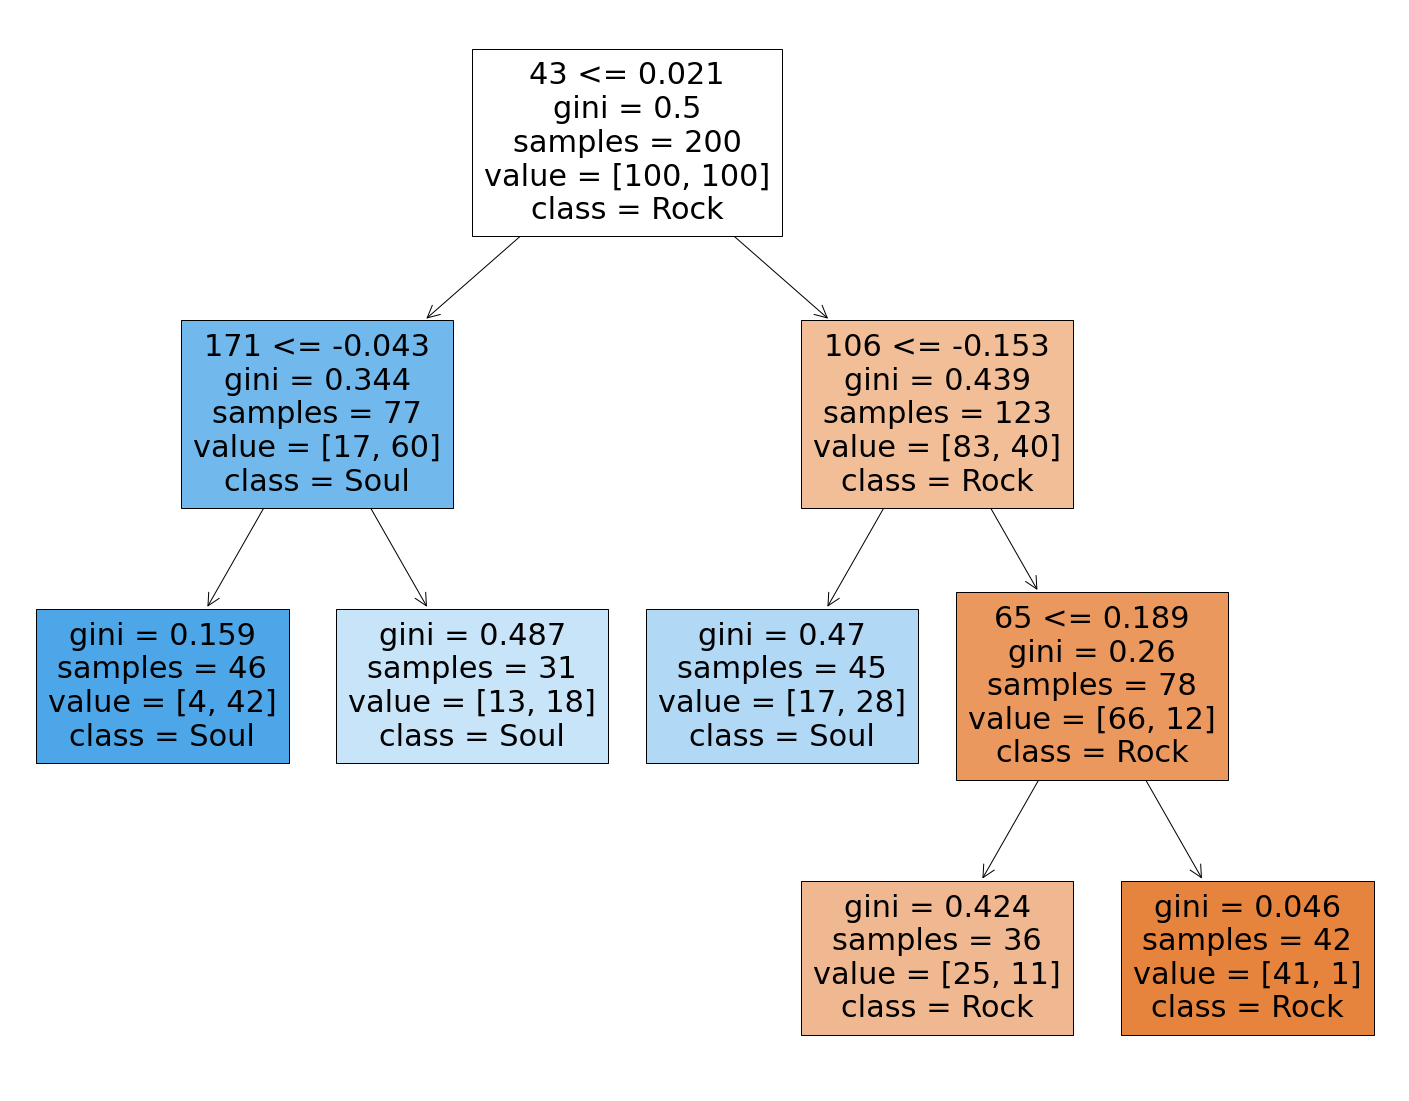

In [9]:
# build and plot a decision tree
from sklearn import tree
from matplotlib import pyplot as plt

# beautify feature names for decision tree for visualization
features=dfX.columns

# learn and plot tree
clf = tree.DecisionTreeClassifier(min_samples_leaf=25)
clf = clf.fit(dfX, dfY)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names=features,
                   class_names=dfY['Genre'].unique(),
                   filled=True)

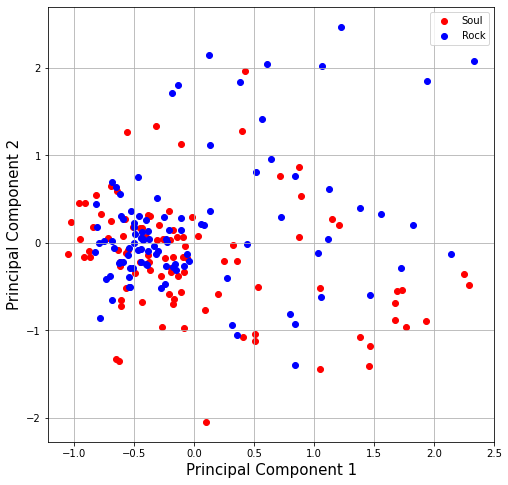

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(dfX)
principalDf = pd.DataFrame(data = pca_result
             , columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, dfY], axis = 1)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)

targets = ['Soul','Rock']
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Genre'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color)
ax.legend(targets)
ax.grid()